# Univariate Linear Regression Demo

> ☝_You might want to read more about_ [_the math behind the Linear Regression_](https://github.com/trekhleb/homemade-machine-learning/tree/master/homemade/linear_regression) _before moving on with this demo._

**Linear regression** is a linear model, e.g. a model that assumes a linear relationship between the input variables `(x)` and the single output variable `(y)`. More specifically, that output variable `(y)` can be calculated from a linear combination of the input variables `(x)`.

**Univariate Linear Regression** is a linear regression that has only _one_ input parameter and one output label. For example in this demo we will build a model that will predict `Happiness.Score` for the countries based on `Economy.GDP.per.Capita` parameter. 

In [1]:
# To make debugging of linear_regression module easier we enable imported modules autoreloading feature.
# By doing this you may change the code of linear_regression library and all these changes will be available here.
%load_ext autoreload
%autoreload 2

# Add project root folder to module loading paths.
import sys
sys.path.append('../..')

### Import Dependencies

- [pandas](https://pandas.pydata.org/) - library that we will use for loading and displaying the data in a table
- [numpy](http://www.numpy.org/) - library that we will use for linear algebra operations
- [matplotlib](https://matplotlib.org/) - library that we will use for plotting the data
- [linear_regression](https://github.com/trekhleb/homemade-machine-learning/blob/master/src/linear_regression/linear_regression.py) - custom implementation of linear regression

In [2]:
# Import 3rd party dependencies.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import custom linear regression implementation.
from homemade.linear_regression import LinearRegression

### Load the Data

In this demo we will use [World Happindes Dataset](https://www.kaggle.com/unsdsn/world-happiness#2017.csv) for 2017.

In [3]:
# Load the data.
data = pd.read_csv('../../data/world-happiness-report-2017.csv')

# Print the data table.
data.head(10)

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182
5,Netherlands,6,7.377,7.427426,7.326574,1.503945,1.428939,0.810696,0.585384,0.470490,0.282662,2.294804
6,Canada,7,7.316,7.384403,7.247597,1.479204,1.481349,0.834558,0.611101,0.435540,0.287372,2.187264
7,New Zealand,8,7.314,7.379510,7.248490,1.405706,1.548195,0.816760,0.614062,0.500005,0.382817,2.046456
8,Sweden,9,7.284,7.344095,7.223905,1.494387,1.478162,0.830875,0.612924,0.385399,0.384399,2.097538
9,Australia,10,7.284,7.356651,7.211349,1.484415,1.510042,0.843887,0.601607,0.477699,0.301184,2.065211


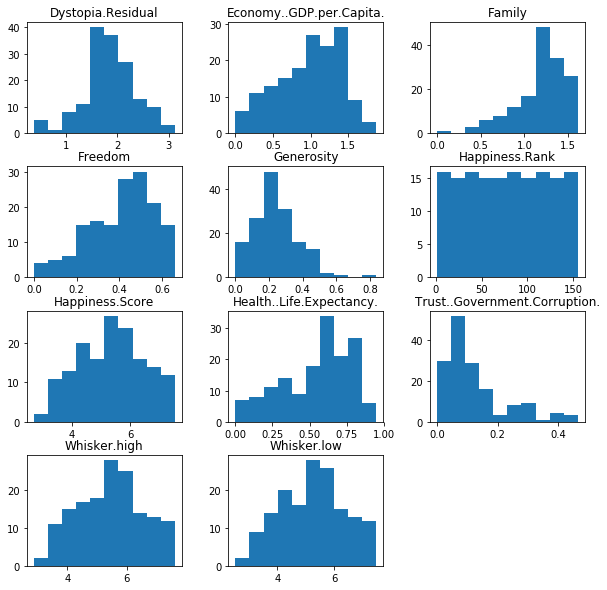

In [4]:
# Print histograms for each feature to see how they vary.
histohrams = data.hist(grid=False, figsize=(10, 10))

### Split the Data Into Training and Test Subsets

In this step we will split our dataset into _training_ and _testing_ subsets (in proportion 80/20%).

Training data set will be used for training of our linear model. Testing dataset will be used for validating of the model. All data from testing dataset will be new to model and we may check how accurate are model predictions.

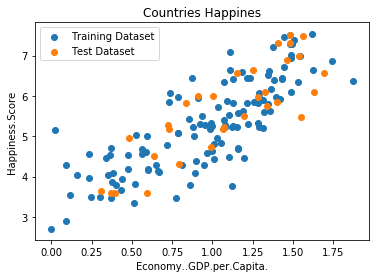

In [5]:
# Split data set on training and test sets with proportions 80/20.
# Function sample() returns a random sample of items.
train_data = data.sample(frac=0.8)
test_data = data.drop(train_data.index)

# Decide what fields we want to process.
input_param_name = 'Economy..GDP.per.Capita.'
output_param_name = 'Happiness.Score'

# Split training set input and output.
x_train = train_data[[input_param_name]].values
y_train = train_data[[output_param_name]].values

# Split test set input and output.
x_test = test_data[[input_param_name]].values
y_test = test_data[[output_param_name]].values

# Plot training data.
plt.scatter(x_train, y_train, label='Training Dataset')
plt.scatter(x_test, y_test, label='Test Dataset')
plt.xlabel(input_param_name)
plt.ylabel(output_param_name)
plt.title('Countries Happines')
plt.legend()
plt.show()

Now we may visualize the data sets to see theirs shape.

### Init and Train Linear Regression Model

> ☝🏻This is the place where you might want to play with model configuration.

- `polynomial_degree` - this parameter will allow you to add additional polynomial features of certain degree. More features - more curved the line will be.
- `num_iterations` - this is the number of iterations that gradient descent algorithm will use to find the minimum of a cost function. Low numbers may prevent gradient descent from reaching the minimum. Hight numbers will make the algorithm work longer without improving its accuracy.
- `learning_rate` - this is the size of the gradient descent step. Small learning step will make algorithm work longer and will probably require more iterations to reach the minimum of the cost function. Big learning steps may couse missing the minimum and growth of the cost function value with new iterations.
- `regularization_param` - parameter that will fight overfitting. The higher the parameter, the simplier is the model will be.
- `polynomial_degree` - the degree of additional polynomial features (`x1^2 * x2, x1^2 * x2^2, ...`). This will allow you to curve the predictions.
- `sinusoid_degree` - the degree of sinusoid parameter multipliers of additional features (`sin(x), sin(2*x), ...`). This will allow you to curve the predictions by adding sinusoidal component to the prediction curve.

In [6]:
# Set up linear regression parameters.
num_iterations = 500  # Number of gradient descent iterations.
regularization_param = 0  # Helps to fight model overfitting.
learning_rate = 0.01  # The size of the gradient descent step.
polynomial_degree = 0  # The degree of additional polynomial features.
sinusoid_degree = 0  # The degree of sinusoid parameter multipliers of additional features.

# Init linear regression instance.
linear_regression = LinearRegression(x_train, y_train, polynomial_degree, sinusoid_degree)

# Train linear regression.
(theta, cost_history) = linear_regression.train(
    learning_rate,
    regularization_param,
    num_iterations
)

# Print training results.
print('Initial cost: {:.2f}'.format(cost_history[0]))
print('Optimized cost: {:.2f}'.format(cost_history[-1]))

# Print model parameters
theta_table = pd.DataFrame({'Model Parameters': theta.flatten()})
theta_table.head()

Initial cost: 218351.71
Optimized cost: 3598.03


,Model Parameters
0,5.241142
1,1.057455


### Analyze Gradient Descent Progress

The plot below illustrates how the cost function value changes over each iteration. You should see it decreasing. 

In case if cost function value increases it may mean that gradient descent missed the cost function minimum and with each step it goes further away from it. In this case you might want to reduce the learning rate parameter (the size of the gradient step).

From this plot you may also get an understanding of how many iterations you need to get an optimal value of the cost function. In current example you may see that there is no much sense to increase the number of gradient descent iterations over 500 since it will not reduce cost function significantly.  

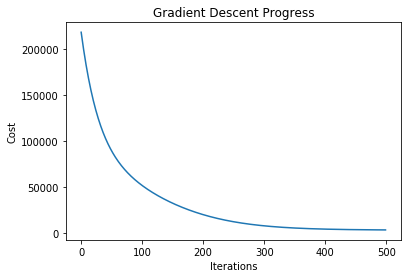

In [7]:
# Plot gradient descent progress.
plt.plot(range(num_iterations), cost_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Gradient Descent Progress')
plt.show()

### Plot the Model Predictions

Since our model is trained now we may plot its predictions over the training and test datasets to see how well it fits the data.

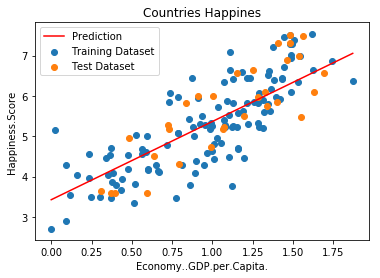

In [8]:
# Get model predictions for the trainint set.
predictions_num = 100
x_predictions = np.linspace(x_train.min(), x_train.max(), predictions_num).reshape(predictions_num, 1);
y_predictions = linear_regression.predict(x_predictions)

# Plot training data with predictions.
plt.scatter(x_train, y_train, label='Training Dataset')
plt.scatter(x_test, y_test, label='Test Dataset')
plt.plot(x_predictions, y_predictions, 'r', label='Prediction')
plt.xlabel('Economy..GDP.per.Capita.')
plt.ylabel('Happiness.Score')
plt.title('Countries Happines')
plt.legend()
plt.show()

Calculate the value of cost function for the training and test data set. The less this value is, the better.

In [9]:
train_cost = linear_regression.get_cost(x_train, y_train, regularization_param)
test_cost = linear_regression.get_cost(x_test, y_test, regularization_param)

print('Train cost: {:.2f}'.format(train_cost))
print('Test cost: {:.2f}'.format(test_cost))

Train cost: 3598.03
Test cost: 276.53


Let's now render the table of prediction values that our trained model does for unknown data (for test dataset). You should see that predicted happiness score should be quite similar to the known happiness score fron the test dataset.

In [10]:
test_predictions = linear_regression.predict(x_test)

test_predictions_table = pd.DataFrame({
    'Economy GDP per Capita': x_test.flatten(),
    'Test Happiness Score': y_test.flatten(),
    'Predicted Happiness Score': test_predictions.flatten(),
    'Prediction Diff': (y_test - test_predictions).flatten()
})

test_predictions_table.head(10)

,Economy GDP per Capita,Test Happiness Score,Predicted Happiness Score,Prediction Diff
0,1.480633,7.504,6.276162,1.227839
1,1.564980,7.494,6.497346,0.996654
2,1.479204,7.316,6.272415,1.043585
3,1.405706,7.314,6.079678,1.234322
4,1.535707,6.977,6.420583,0.556417
5,1.463781,6.891,6.231969,0.659030
6,1.252785,6.652,5.678667,0.973333
7,1.153184,6.578,5.417481,1.160519
8,1.692278,6.572,6.831164,-0.259164
9,1.632952,6.105,6.675594,-0.570594
